# MLBD / Lab 2 / Features extraction

## <p style="background-color:#bb2222; color:#fff;padding:5px; font-weight:bold">Report submission</p>

This laboratory will be graded, so you have to submit a report. You can work in groups of up to 3 persons and submit a report for each group with the following constraint :

- the report must be **AT MOST** 4 pages
- it should contains answer to the questions asked in this notebook
- it should contains an explanation of the feature you implemented with an overview of how it works (e.g. show some examples) and why you think it is useful
- include your results (either as classification report or confusion matrix) for both the kNN and the neural network classifiers
- include a graph showing the training error of your neural network over epochs (like the example ones at the end of this notebook)
- include the parameters you chosed for the neural network (number of neurons, learning rate, momentum, number of epochs) and why you picked them
- include an analysis of your results

Also include a copy of your scripts (.ipynb or .py) that you used WITHOUT the data. The grading will **ONLY be based on the report** and if we have to look at your scripts to understand what you did, it's a bad sign.


## Introduction

In this laboratory, we will work with images of plant leaves. The goal is to identify the plant species from the image.

To do so, we will use some concepts that have been presented in the theoretical part of the course :
- Feature extraction to turn an image into a vector of features
    - This will involve using PCA (Principal Component Analysis)
- Multi-Layer Perceptron (a type of artificial neural network) to perform the classification

### Dataset information

We will use the ImageClef 2012 Plant classification dataset. To simplify things, we have already extracted a small part of the dataset that we will be working on (in the "data/preprocessed" directory).

The notebook additionals/lab2_preprocess contains the preprocessing code (background substraction, image size normalization) that was used to create the subset of the data used in this laboratory.

Note that **it is not required** to download the full dataset. Neither do you need to run the lab2_preprocess notebook as this has already been done for you. But you can have a look if you are interested.

The full dataset can be downloaded from : 

http://www.imageclef.org/2012/plant

The direct link is :

http://otmedia.lirmm.fr/LifeCLEF/ImageCLEF2011-2012-2013/ImageCLEF2012PlantIdentificationTaskFinalPackage.zip

It is interesting to download this dataset and have a look at the files in *data/SomeStatAndHtmlViewBySpecies/TrainAndTestViewsBySpecies*, which gives a nice overview of the type of plants in the dataset.

This dataset was originally used in a challenge. In the *OralPresentationsAndPosters* directory, there are some presentations from the teams that participated in the challenge with information about the type of preprocessing, features and classifiers used. This is very interesting if you are looking for inspiration about what you could implement.


<p style="background-color:#bb2222; color:#fff;padding:5px; font-weight:bold">Note about OpenCV</p>

We will use the OpenCV image processing library to extract some features from the images. You can install it using anaconda with the following command :

    $ conda install opencv
    
You should then be able to import the OpenCV python module, called **cv2**.

## Dataset overview

In [126]:
import os
import cv2 # opencv
import pandas as pd
import numpy.ma as ma
import numpy.linalg as la
import skimage
import skimage.io
import pylab as pl
import matplotlib.cm as cm
%pylab inline --no-import-all
np.set_printoptions(precision=5, suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
DIR = 'data/preprocessed/'
meta = pd.io.pickle.read_pickle(os.path.join(DIR, 'meta.pkl'))

def load_img(name):
    """Loads the given image by name and returns a masked array"""
    img = skimage.io.imread(os.path.join(DIR, 'imgs', name + ".png"))
    img = skimage.img_as_float(img)
    img = ma.masked_where(img == 0, img)
    # same mask for all 3 axes
    mask = np.all(img == 0, axis=2)
    img = ma.array(img)
    for i in xrange(img.shape[2]):
        img.mask[:,:,i] = mask
    
    return img

The meta dataframe contains information for each image :

- *basename* is the filename (without extension) of the image.
- *content* gives information about the image content. To simplify the problem, we selected only images of plant leaves on uniform backgrounds, but the original dataset has more variety. 
- *classid* is the class. We selected 9 classes from the original dataset.
- *photo_type* is the type of photo. To simplify, we used only scan and pseudoscan (=uniform background) images

In [3]:
meta.iloc[:5]

,basename,content,classid,photo_type
49,10047,leaf,arbutus unedo,pseudoscan
70,10073,leaf,nerium oleander,pseudoscan
85,10092,leaf,nerium oleander,scan
117,10129,leaf,acer campestre,scan
123,10135,leaf,quercus pubescens,pseudoscan


You can use the *load_img* function to load an image. 

**masked arrays** Note that we are using [numpy *masked* arrays](http://docs.scipy.org/doc/numpy/reference/maskedarray.html), which are a special type of numpy array that have a mask. The mask is a boolean array that indicates if an entry is valid (mask[i,j] == False) or invalid (mask[i,j] == True). For our images, the background pixels are all masked. You can access the mask by using the .mask attribute of the array. Below, we use img.filled(1) to get a copy of the array with masked values replaced by 1. 

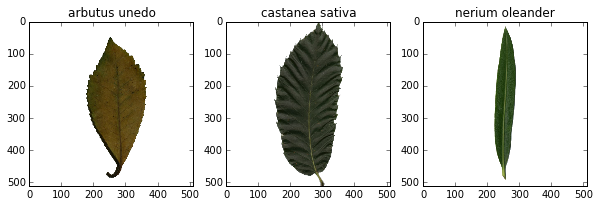

In [4]:
# Show 3 example images
examples = [0, 50, 300]

pl.figure(figsize=(10, 3))
for i, idx in enumerate(examples): 
    pl.subplot(1, 3, i + 1)
    img = load_img(meta.iloc[idx]['basename'])
    pl.title(meta.iloc[idx]['classid'])
    pl.imshow(img.filled(1))

In [5]:
# The classes we will work with
print np.unique(meta['classid'])

['acer campestre' 'ailanthus altissima' 'alnus glutinosa' 'arbutus unedo'
 'castanea sativa' 'liquidambar styraciflua' 'nerium oleander'
 'quercus pubescens' 'vitex agnus-castus']


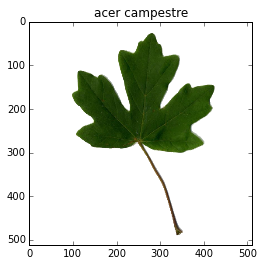

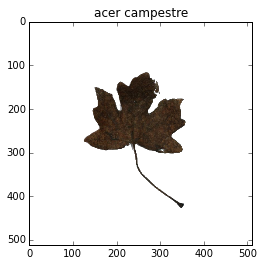

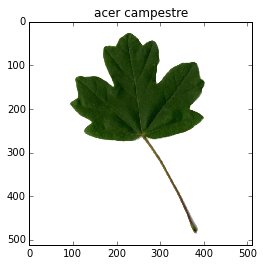

In [6]:
# You can plot some examples images for a given species
import random
examples = np.flatnonzero(meta['classid'] == 'acer campestre')

for idx in random.sample(examples, 3):
    pl.figure()
    img = load_img(meta.iloc[idx]['basename'])
    pl.title(meta.iloc[idx]['classid'])
    pl.imshow(img.filled(1))

## Features extraction

So, we have images of leaves and we want to train a classifier to automatically determine the species of a leaf.

What should we use as input vectors for our classifier ?

The bruteforce approach could be to use a flattened version of all the image pixels (you concatenate all the rows in the image). Since we have images that have a size of 512x512, this would result in 262144 (512*512) dimensional input vectors.

For most classifiers, this is way too much dimensions. Also, this would mean that if you translate your image by one pixel, the input vector will change dramatically. Later in the course, we will see that deep learning classifiers are able to use data in such an unprocessed form, but for now, we have to extract features.

The better approach is to extract features to represent each image. If we ask you to manually classify those images, what will you look at ? Color ? The general shape of the leaf (i.e. elongated, round) ? The texture of the leaf ?

We will try to extract features that allow our classifier to use the same kind of hints that a human would use. We will start with two features : *eccentricity* and *curvature*. You will then have to propose and implement a new feature and see how the new information impacts classification performance.

First, we define some utility functions :

In [9]:
def get_plant_points(img):
    """
    Given the image of a plant, returns a Nx2 array containing the (x, y) coordinate
    of all non-masked points
    """
    # this returns (y, x) tuple
    points = np.transpose(np.nonzero(~img.mask)[:2])
    # makes that an (x, y) tuple
    points = np.roll(points, 1, axis=1)
    return points

def extract_contour(img):
    """
    Wrapper around OpenCV's contour extraction methods. This returns only the longest
    contour
    """
    contours, hierarchy = cv2.findContours(
        skimage.img_as_ubyte(~img.mask[:,:,0]),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_NONE
    )

    # only take longest contour into account
    longest_contour = np.argmax([len(c) for c in contours])
    cnt = contours[longest_contour]
    cnt = np.squeeze(cnt)
    return cnt

### Eccentricity

Eccentricity gives us information about how the distribution of the leaf points deviates from a perfect circle.

The *get_plant_points* method above gives us the coordinate $(x, y)$ of all foreground (non-masked) points in the image. If we perform PCA on those points, we get two orthogonal (uncorrelated) principal axis (components) which are :

- The first axis is the axis with maximum variance
- The second axis is orthogonal to the first

In addition, each axis (which are the eigenvectors of the covariance matrix of our data) has an associated eigenvalue. The eigenvalue informs us about the relative importance of each axis.

We compute the eccentricity as the ratio of the eigenvalues of the two axis. If our points are distributed in a perfect circle, both axes will have equal importance and the ratio will be 1.

In [7]:
from sklearn.decomposition import PCA

def eccentricity(img, plot=False):
    """Compute eccentricity : the ratio of the eigenvalues of principal components"""
    points = get_plant_points(img)
    pca = PCA(n_components=2).fit(points)
    centroid = pca.mean_
    eccentricity = pca.explained_variance_[0] / pca.explained_variance_[1]

    if plot:
        pl.title('eccentricity : %f' % eccentricity)
        pl.imshow(img)
        
        # direction of the two principal components
        d1 = pca.components_[0,:]
        d2 = pca.components_[1,:]
        
        scale = 100
        p1 = centroid + scale * d1 * pca.explained_variance_ratio_[0]
        pl.plot([centroid[0], p1[0]], [centroid[1], p1[1]], c='r')
        
        p2 = centroid + scale * d2 * pca.explained_variance_ratio_[1]
        pl.plot([centroid[0], p2[0]], [centroid[1], p2[1]], c='y')
        
        pl.xlim((0, img.shape[1]))
        pl.ylim((img.shape[0], 0))
        
    return eccentricity

First, let's play with circles and ellipses

4.0057977326922609

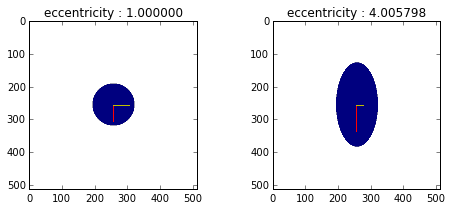

In [10]:
import skimage.draw

def get_ellipse_image(yradius, xradius):
    img = ma.masked_all((512, 512), dtype=np.float)
    rr, cc = skimage.draw.ellipse(256, 256, yradius=yradius, xradius=xradius, shape=(512, 512))
    img[rr, cc] = 1
    return img

pl.figure(figsize=(8, 3))
pl.subplot(121)
# This is a circle
eccentricity(get_ellipse_image(64, 64), plot=True)

pl.subplot(122)
# An ellipse
eccentricity(get_ellipse_image(128, 64), plot=True)

Ok so now we can apply eccentricity on our images

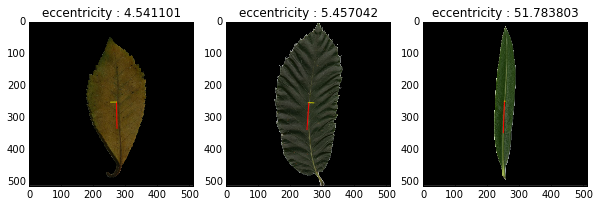

In [10]:
examples = [0, 50, 300]
pl.figure(figsize=(10, 3))
for i, idx in enumerate(examples): 
    pl.subplot(1, 3, i + 1)
    img = load_img(meta.iloc[idx]['basename'])
    eccentricity(img, plot=True)

### Curvature

We will compute the [curvature](http://en.wikipedia.org/wiki/Curvature#Curvature_of_plane_curves) of the contour of the leaf. This will help describe the "pointiness" of the contour.

The function does the following steps :

- Extract the leaf contour (using OpenCV's contour extraction functions).
- Compute the curvature for each point on the contour.
- Compute an histogram of all the curvatures of contour points.

The final feature vector will be the histogram. The number of bins in the histogram define the dimensionality of the feature vector.

There are three parameters that are important when computing our curvature feature :

- *step* : To compute curvature for a given point, we need a previous and next point and then use those 3 points to construct a circumcircle, the (inverse of the) radius of which is the curvature. The step determine how far away we pick our previous and next point.

<img width="200px" src="http://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Osculating_circle.svg/460px-Osculating_circle.svg.png" />

- *nbins* and *vmax* : When computing our histogram of curvatures, we have to decide the number of bins in the histogram. We also have to decide the range of the bins, which will be in [0, vmax] . 

In [11]:
from matplotlib import gridspec

def circumcircle_radius(p1, p2, p3):
    """
    Given 3 points of a triangle, computes the radius of the circumcircle
    http://www.mathopenref.com/trianglecircumcircle.html

    This function can return np.inf if the triangle has an area of zero
    """
    a = la.norm(p2 - p1)
    b = la.norm(p3 - p2)
    c = la.norm(p1 - p3)
    #print a, b, c

    # Check for degenerate case (triangle has an area of zero)
    denom = np.fabs((a+b+c)*(b+c-a)*(c+a-b)*(a+b-c))
    if abs(denom) < 1e-5:
        return np.inf
    else:
        r = (a * b * c)/np.sqrt(denom)
        return r

def curvature_from_cnt(line, step=10):
    """
    Curvature computation for a line given as a Nx2 array
    We assumes the line is closed (ie the last and first point are contiguous)

    Each set of 3 consecutive (see step) points on the line forms a triangle
    and the radius of the circumcircle of this triangle is the radius of
    the curve for that set. The curvature is 1/r where r is this radius.

    Taking immediatly consecutive points doesn't work well, so `step` specify
    how points triplets are formed : (i-step, i, i+step)
    """
    # Append line end at beginning and beginning at end to simulate closed
    # line
    l = np.r_[line[-1].reshape(-1, 2),
              np.array(line),
              line[0].reshape(-1, 2)]
    curv = []
    linelen = line.shape[0]
    for i in xrange(linelen):
        # indices in l are shifted by -1
        #r = circumcircle_radius(l[i], l[i+1], l[i+2])
        r = circumcircle_radius(line[(i-step)%linelen],
                                line[i],
                                line[(i+step)%linelen])
        if np.isinf(r):
            # Flat => curvature = 0
            curv.append(0)
        else:
            curv.append(1.0 / r)
    return np.array(curv)

def curvature(img, step=10, plot=False, gs=None):
    cnt = extract_contour(img)
    
    cvt = curvature_from_cnt(cnt, step=step)
    
    if plot:
        if gs is None:
            gs = gridspec.GridSpec(1, 2)
        vimg = skimage.img_as_ubyte(img)
        cv2.drawContours(vimg, [cnt], 0, (0,255,0), 3)
        
        pl.subplot(gs[0])
        pl.title('contour')
        pl.imshow(vimg)
        pl.axis('off')
        
        pl.subplot(gs[1])
        pl.title('curvature')
        pl.imshow(img)
        pl.scatter(cnt[:,0], cnt[:,1], c=cvt, linewidths=0, s=5)
        pl.xlim((0, img.shape[1]))
        pl.ylim((img.shape[0], 0))
        pl.axis('off')
        
    return cvt

<p style="background-color:#660066; color:#fff;padding:5px; font-weight:bold">Q: Implement the curvature_hist function.</p>

This function should take an image as input and return a vector of dimension $n$ representing the histogram of contour curvatures for the given image with $n$ bins. The signature should be :

    def curvature_hist(img, step=10, plot=False):
        # implement here


In [112]:
def curvature_hist(img, step=10, plot=False):
    c = curvature(img, step, plot)
    
    binwidth = 0.02
    bins = np.arange(0, 0.5, binwidth)
    h, edges = np.histogram(c, bins=bins)
    if plot:
        pl.show()
        pl.title('Histogramme')
        pl.hist(c, bins=bins,normed = 1, alpha=0.5, rwidth = 0.7)
        pl.xlabel('Curvature')
        pl.ylabel('Nb')
        pl.subplots_adjust(left=0.15)
        pl.show()
    
    return h
    

In [38]:
m1 = meta['classid'] == 'alnus glutinosa'
m2 = meta['classid'] == 'acer campestre'
print np.flatnonzero(m1)
print np.flatnonzero(m2)

[ 19  44  64 170 178 194 208 214 232 250 286 303 306 313 328 338 421 423
 433 444 478 484 507 512 516 537 540 574]
[  3   6  11  14  17  24  43  63  78  80  91  95 111 125 126 129 130 146
 182 200 213 246 248 264 273 280 281 282 289 290 292 295 307 318 319 325
 339 355 360 375 384 411 420 427 430 434 436 453 454 458 460 463 464 465
 508 510 513 527 530 531 541 552 555 557 558 562 566]


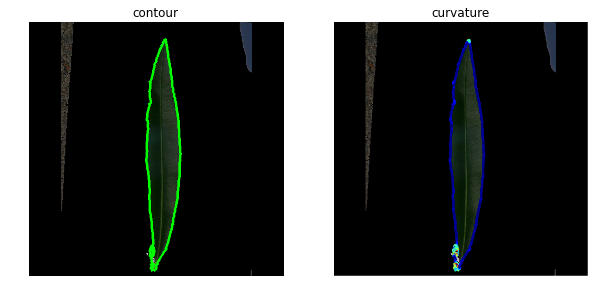

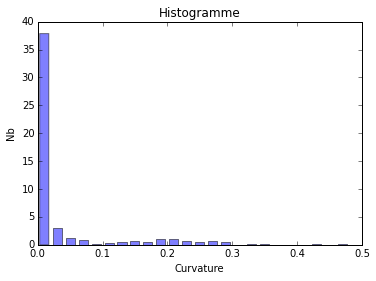

[813  65  26  18   4   8  10  14  11  21  22  14  10  13   9   1   2   3
   0   1   1   3   1   4]


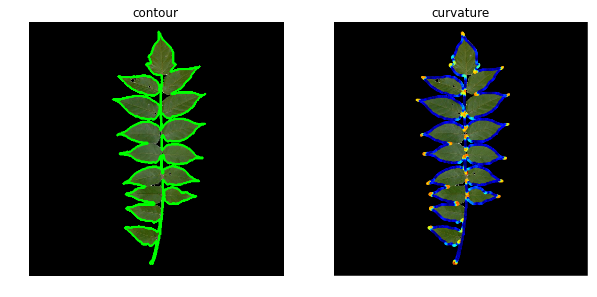

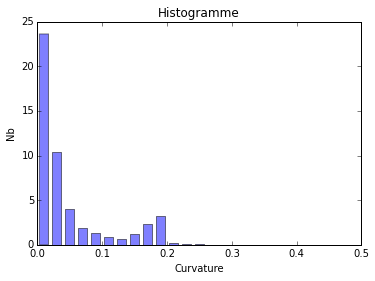

[1355  596  230  111   76   52   39   71  132  185   13    6    3    0    0
    0    0    0    0    0    0    0    0    0]


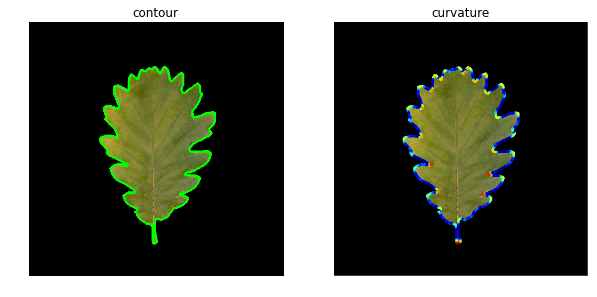

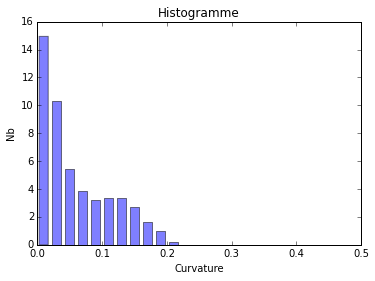

[398 275 144 102  86  90  89  72  44  26   6   0   0   0   0   0   0   0
   0   0   0   0   0   0]


In [113]:

examples = [1, 13, 7]
#examples = [19, 44, 3, 6]

for i, idx in enumerate(examples): 
    pl.figure(figsize=(10, 5))
    img = load_img(meta.iloc[idx]['basename'])
    c = curvature_hist(img, step=10, plot=True)
    print c
    

### Implement your own features

http://www.math.uci.edu/icamp/summer/research_11/park/shape_descriptors_survey.pdf

<p style="background-color:#660066; color:#fff;padding:5px; font-weight:bold">Q: Implement a new feature</p>

Implement a new feature extractor that you think could be useful for this classification task. Explain why your feature extractor is useful. You can look at the presentations accompanying the original dataset for inspiration. You can also start building on the convex hull example below.

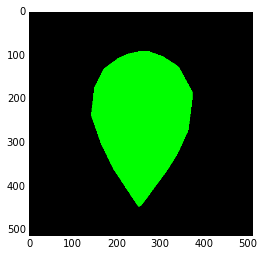

In [16]:
# As an example, OpenCV allows you to compute the convex hull of a shape. An idea of feature might be
# to compute the ratio of area covered by valid pixels versus the convex hull area
cnt = extract_contour(img)
hull = cv2.convexHull(cnt)
vimg = skimage.img_as_ubyte(img)
cv2.drawContours(vimg, [hull], 0, (0,255,0), -1)
pl.imshow(vimg)

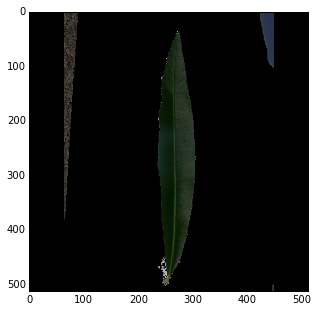

Area / Perimeter : 17.6366649245


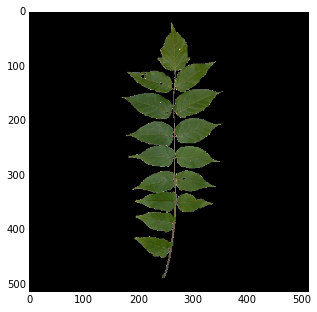

Area / Perimeter : 10.0589422441


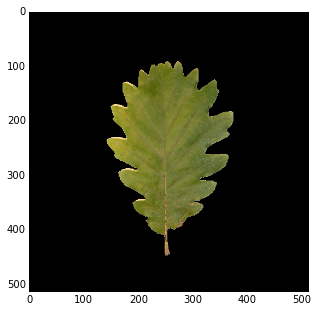

Area / Perimeter : 29.7991022593


In [122]:
def ratioAreaPerimeter(img, plot=False):
    cnt = extract_contour(img)
    perimeter = cv2.arcLength(cnt,True)
    area = cv2.contourArea(cnt)
    
    if plot:
        pl.imshow(img)
        pl.show()
        
    return area / perimeter

examples = [1, 13, 7]
for i, idx in enumerate(examples): 
    pl.figure(figsize=(10, 5))
    img = load_img(meta.iloc[idx]['basename'])
    c = ratioAreaPerimeter(img, True)
    print "Area / Perimeter : " + str(c)



<p style="background-color:#660066; color:#fff;padding:5px; font-weight:bold">Q: Use the features to train and evaluate a k-NN classifier</p>

This involves :

- Compute the feature vector of each image (by concatenating individual features of the image).
- Build a $n$ x $m$ data matrix $X$ with the feature vectors of all the images, where $n$ is the number of images and $m$ the number of features.
- Build an integer vector of length $n$, $y$, containing the target class for each image. *sklearn.preprocessing.LabelEncoder* is useful for converting text labels into integers.
- Split your dataset into training and test : X_train, X_test, y_train, y_test. *sklearn.cross_validation* has useful utility functions for that.
- Normalizing your data. *sklearn.preprocessing.MinMaxScaler* might be useful (or other similar scaler classes)
- Build a classifier with *sklearn.neighbors.KNeighborsClassifier* on your training dataset and evaluate on your test dataset.
    - this the *y_pred = knn.predict(X_test)* cell

After you have evaluated your model **write a short analysis of your results**.


In [169]:
#
# Your KNN code here
#

from sklearn import neighbors

def extract_features_vector(img):
    
    #Features : eccentricity, curvature_hist, ratio area/perimeter
    e = eccentricity(img)
    c_hist = curvature_hist(img)
    r = ratioAreaPerimeter(img)

    features = []
    features.append(e)
    for value in c_hist:
        features.append(value)
    features.append(r)
    
    return features

def create_class_encoder():

    le = sklearn.preprocessing.LabelEncoder()
    
    l = []
    for i in range( 0, len( meta ) - 1 ):
        l.append(meta.iloc[i]['classid'])

    le.fit(l)
    
    return le

lencoder = create_class_encoder()
print(le.classes_)

features = []
classes = []

count = len( meta )

for i in range( 0, count- 1 ):
    
    e = meta.iloc[i]
    
    img = load_img(e['basename'])
    feature = extract_features_vector(img)
    features.append(feature)
    classes.append(lencoder.transform(e['classid']))
    
X = np.asarray(features)

X = preprocessing.StandardScaler().fit_transform(X) # Normalization

y = np.asarray(classes)
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split( X, y, test_size=0.2 )

knn = neighbors.KNeighborsClassifier()
knn.fit( X_train, y_train )
    

['acer campestre' 'ailanthus altissima' 'alnus glutinosa' 'arbutus unedo'
 'castanea sativa' 'liquidambar styraciflua' 'nerium oleander'
 'quercus pubescens' 'vitex agnus-castus']


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform')

In [170]:
y_pred = knn.predict(X_test)

In [171]:
# performance evaluation
import sklearn.metrics as skmetrics
from sklearn.metrics import confusion_matrix

report = skmetrics.classification_report(y_test, y_pred,
                                         labels=np.arange(len(lencoder.classes_)),
                                         target_names=lencoder.classes_)
confmat = confusion_matrix(y_test, y_pred)

In [172]:
def plot_confusion_matrix(confmat, labels_names, ax=None, cmap=None):
    """Utility function to plot a confusion matrix"""
    if ax is None:
        ax = pl.subplot(111)
    cmim = ax.matshow(confmat, interpolation='nearest', cmap=cmap)

    for i in xrange(confmat.shape[0]):
        for j in xrange(confmat.shape[1]):
            ax.annotate(str(confmat[i, j]), xy=(j, i),
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=8)
    ax.set_xticks(np.arange(confmat.shape[0]))
    ax.set_xticklabels([labels_names[l] for l in xrange(confmat.shape[0])], rotation='vertical')
    ax.set_yticks(np.arange(confmat.shape[1]))
    _ = ax.set_yticklabels([labels_names[l] for l in xrange(confmat.shape[1])])
    ax.set_xlabel('predicted label')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('true label')
    pl.colorbar(cmim, shrink=0.7, orientation='horizontal', pad=0.01)

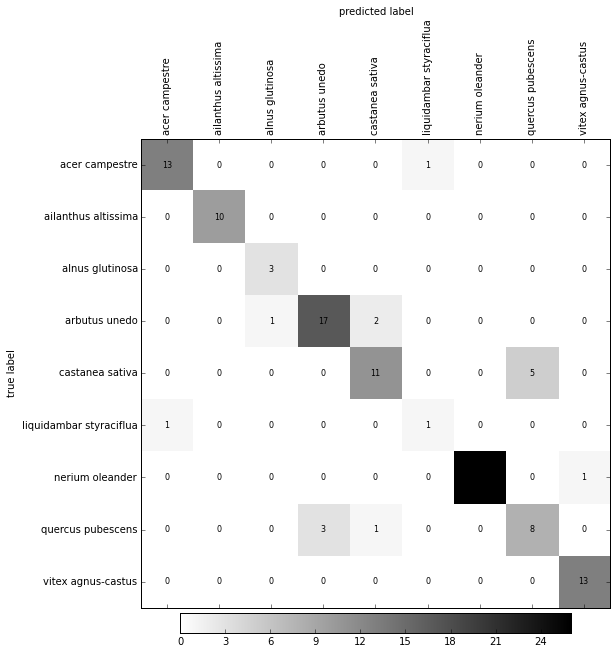

In [150]:
pl.figure(figsize=(10, 10))
plot_confusion_matrix(confmat, lencoder.classes_, cmap=cm.gray_r)

In [159]:
print report

                         precision    recall  f1-score   support

         acer campestre       0.62      1.00      0.76         8
    ailanthus altissima       0.83      1.00      0.91        10
        alnus glutinosa       1.00      0.80      0.89         5
          arbutus unedo       0.94      0.83      0.88        18
        castanea sativa       0.70      0.64      0.67        11
liquidambar styraciflua       1.00      0.67      0.80         9
        nerium oleander       1.00      0.96      0.98        26
      quercus pubescens       0.79      0.85      0.81        13
     vitex agnus-castus       1.00      1.00      1.00        17

            avg / total       0.90      0.88      0.88       117



## Multilayer Perceptron with pybrain

**pybrain** is a python machine learning library (similar to scikit-learn) that implements artificial neural networks.

Install pybrain with: 

    $ pip install pybrain

The pybrain documentation has a tutorial on supervised classification with a feed-forward network :

http://pybrain.org/docs/tutorial/fnn.html

<p style="background-color:#660066; color:#fff;padding:5px; font-weight:bold">Q: Train a feed-forward neural network to perform plant species classification.</p>
    
You will most likely need the following pybrain functions :

    from pybrain.tools.shortcuts     import buildNetwork
    from pybrain.supervised.trainers import BackpropTrainer
    from pybrain.structure.modules   import SoftmaxLayer
    from pybrain.utilities           import percentError
    
You have to build a network, then create a trainer for the network :

    fnn = buildNetwork(ds_train.indim, n_hidden_units, ds_train.outdim, outclass=SoftmaxLayer)

Then, you iterate a fixed number of time (epochs) and call trainer.trainEpochs(1) at each iteration.
On each iteration, you should evaluate the performance of your network on you training and test set :

    result_train = percentError(trainer.testOnClassData(),
                                ds_train['class'] )
    result_test = percentError(trainer.testOnClassData(
           dataset=ds_test ), ds_test['class'] )
           
At the end of training, show a plot with the test and train error vs. epochs.

The variable containing your network should be called *fnn* and we give you the code to run the trained network on the test set and plot a classification report and confusion matrix.

<p style="background-color:#660066; color:#fff;padding:5px; font-weight:bold">Q: Play with the BackpropTrainer parameters.</p>
Explore the backproptrainer parameters and try to find a good set of parameters. The main parameters are : *learningrate*, *momentum*, the number of hidden units in your network and the number of updates performed by the algorithm (epochs).

Start by setting the number of units in the hidden layer (to something small, <20) and the number of epochs (50-150). Play with the learning rate (0.0-1.0) and momentum (0.0-1.0) and verify if the train and test errors decrease with the number of epochs (for example with a plot). You also want to avoid oscillations in the errors.

<table>
<tr><th>Bad</th><th>Good</th></tr>
<tr>
    <td><img width="300px" src="files/bad_training.png"></td>
    <td><img width="300px" src="files/good_training.png"></td>
</tr>
</table>

Once you have found good values for the learning rate and momentum, you can try modifying the number of epochs and the size of the hidden layer. On the one hand, you should choose a number of epochs so that the errors reaches a plateau, stopping the training when the error does not decrease anymore. On the other hand, you have to make your neural network sufficiently complex to obtain a good classification performance, while keeping it as simple as possible to avoid over-fitting.

The classification performance will most likely be close to but lower than what you obtained with k-NN.

<p style="background-color:#660066; color:#fff;padding:5px; font-weight:bold">Q: Answer the following questions :</p>

- How many output units are there in the network you trained ? Why ?
- How many parameters (weights and biases) are there in your network ? Why ?
    - hint: you can use *fnn.params* to get the parameters of your network

*pybrain* uses its own dataset class. To simplify things, we provide example code to transform X_train, y_train, X_test, y_test into a two pybrain dataset objects : *ds_train* and *ds_test* .

In [173]:
import pybrain
from pybrain.datasets import ClassificationDataSet
from sklearn.preprocessing import MultiLabelBinarizer

# turns integer labels vector like [0, 2, 3, 2] into a binary
# matrix [[1, 0, 0, 0],
#         [0, 0, 1, 0],
#         [0, 0, 0, 1],
#         [0, 0, 1, 0]]
binarizer = MultiLabelBinarizer().fit(y.reshape(-1, 1))

def pybrain_ds_from_Xy(X, y, binarizer):
    """
    Args:
        binarizer: A MultiLabelBinarizer instance
    """
    ds = ClassificationDataSet(X.shape[1], nb_classes=len(lencoder.classes_), class_labels=lencoder.classes_)
    ds.setField('input', X)
    ds.setField('class', y.reshape(-1, 1))
    ds.setField('target', binarizer.transform(y.reshape(-1, 1)))
    
    #print '--'
    #print "class  :\n", ds['class'][5:10]
    #print "target :\n", ds['target'][5:10]
    #print "y      :\n", y[5:10]
    
    return ds

def print_ds(ds):
    print "Number of training patterns: ", len(ds)
    print "Input and output dimensions: ", ds.indim, ds.outdim
    print "First sample (input, target, class):"
    print ds['input'][10], ds['target'][10], ds['class'][10]
    print ds['input'][55], ds['target'][55], ds['class'][55]

ds_train = pybrain_ds_from_Xy(X_train, y_train, binarizer)
ds_test = pybrain_ds_from_Xy(X_test, y_test, binarizer)

In [174]:
print '-- train'
print_ds(ds_train)
print '-- test'
print_ds(ds_test)

-- train
Number of training patterns:  465
Input and output dimensions:  26 9
First sample (input, target, class):
[-0.60172  1.8444   0.11809 -0.8781  -0.90731 -0.72734 -0.52522 -0.54708
 -0.21125  0.15564  0.03957 -0.30053 -0.44127 -0.3458  -0.27059 -0.22923
 -0.20491 -0.16992 -0.16328 -0.11147 -0.14784 -0.12533 -0.06261 -0.06261
 -0.07436 -0.6522 ] [0 0 0 0 0 0 0 0 1] [8]
[ 1.94233 -0.01234 -1.3318  -1.37481 -1.26335 -1.1467  -1.17251 -1.03866
 -0.83104 -0.60575 -0.47061 -0.42141 -0.44127 -0.3458  -0.27059 -0.22923
 -0.20491 -0.16992 -0.16328 -0.11147 -0.14784 -0.12533 -0.06261 -0.06261
 -0.07436 -0.51054] [0 0 0 0 0 0 1 0 0] [6]
-- test
Number of training patterns:  117
Input and output dimensions:  26 9
First sample (input, target, class):
[-0.63631  0.17693  0.00437  0.15789  0.0561   0.77744 -0.39577 -0.16084
 -0.26759 -0.40996 -0.50705 -0.54229 -0.44127 -0.3458  -0.27059 -0.22923
 -0.20491 -0.16992 -0.16328 -0.11147 -0.14784 -0.12533 -0.06261 -0.06261
 -0.07436 -0.27536] [1 0 0

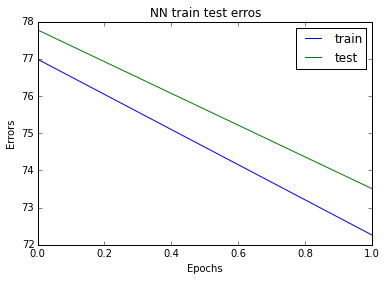

In [189]:
#
# Your neural network code here
#
from pybrain.tools.shortcuts     import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules   import SoftmaxLayer
from pybrain.utilities           import percentError
from datetime import datetime


n_hidden_units = 3

fnn = buildNetwork(ds_train.indim, n_hidden_units, ds_train.outdim, outclass=SoftmaxLayer)

trainer = BackpropTrainer(fnn, ds_train,learningrate=0.01, momentum=0.0)

results_train = []
results_test = []
epochs = range(0,60)


for e in epochs:
    trainer.trainEpochs(1)
    
    results_train.append(percentError(trainer.testOnClassData(),
                            ds_train['class'] ))
    results_test.append(percentError(trainer.testOnClassData(
           dataset=ds_test ), ds_test['class'] ))

    
pl.title('NN train test erros')
pl.plot(epochs, results_train, label = "train")
pl.plot(epochs, results_test, label = "test")
pl.xlabel('Epochs')
pl.ylabel('Errors')
plt.legend()
pl.show()



In [177]:
out = fnn.activateOnDataset(ds_test)
out = out.argmax(axis=1)  # the highest output activation gives the class
y_pred_nn = out.reshape(y_test.shape)

In [178]:
report_nn = skmetrics.classification_report(y_test, y_pred_nn,
                                         labels=np.arange(len(lencoder.classes_)),
                                         target_names=lencoder.classes_)
confmat_nn = confusion_matrix(y_test, y_pred_nn)

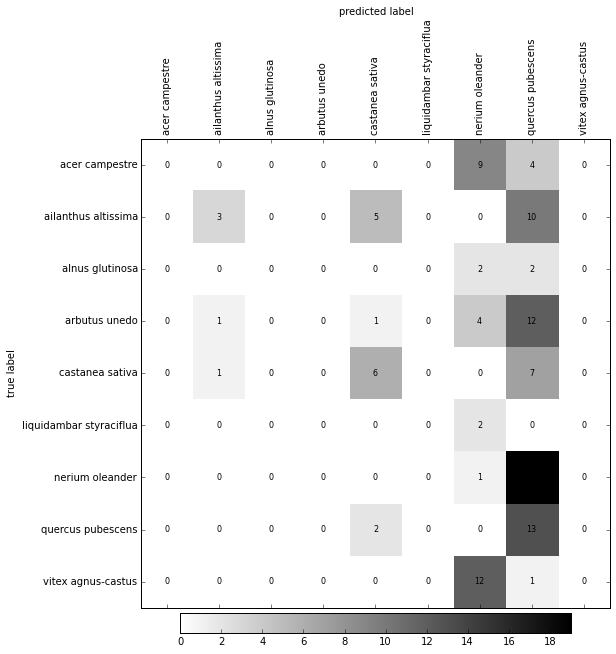

In [179]:
# untrained plot
pl.figure(figsize=(10, 10))
plot_confusion_matrix(confmat_nn, lencoder.classes_, cmap=cm.gray_r)

In [180]:
print report_nn

                         precision    recall  f1-score   support

         acer campestre       0.00      0.00      0.00        13
    ailanthus altissima       0.60      0.17      0.26        18
        alnus glutinosa       0.00      0.00      0.00         4
          arbutus unedo       0.00      0.00      0.00        18
        castanea sativa       0.43      0.43      0.43        14
liquidambar styraciflua       0.00      0.00      0.00         2
        nerium oleander       0.03      0.05      0.04        20
      quercus pubescens       0.19      0.87      0.31        15
     vitex agnus-castus       0.00      0.00      0.00        13

            avg / total       0.17      0.20      0.14       117

